### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BinaryBRSETDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES_PATH = os.path.join(DATASET, 'images/')
LABEL = 'diabetic_retinopathy'
TEST_SIZE = 0.3
UNDERSAMPLE = True

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

BACKBONE = 'retfound'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = None # 756
num_classes = 2

BATCH_SIZE = 32
NUM_WORKERS = 2

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 10
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal


Train data shape: (1830, 35)
Test data shape: (4880, 35)


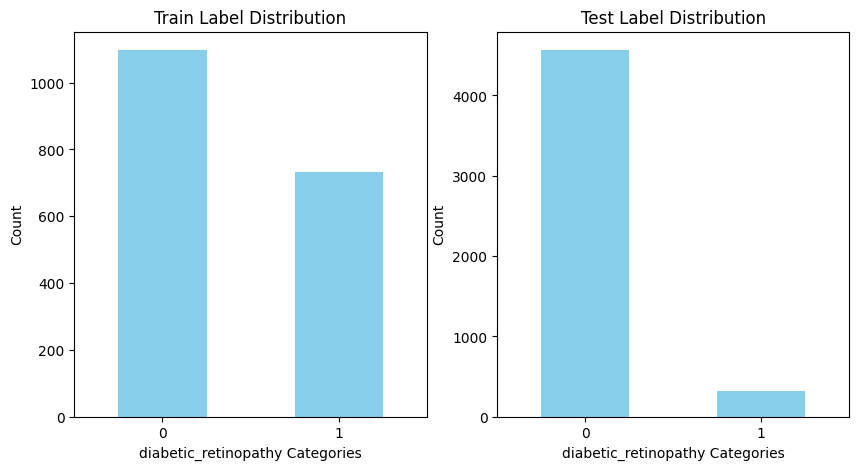

Getting validation set...
Train data shape: (4148, 35)
Test data shape: (732, 35)


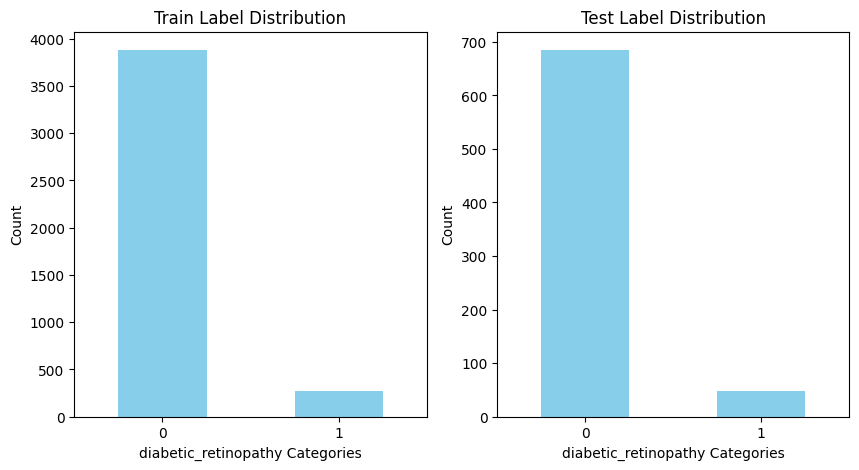

In [4]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=UNDERSAMPLE, undersample_ratio=1.5)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.15)

### Dataloaders

In [5]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [6]:
# Create the custom dataset
train_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_train,
    shape=SHAPE,
    transform=train_transforms,
    label_col=LABEL
)

test_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_test,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

val_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_val,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


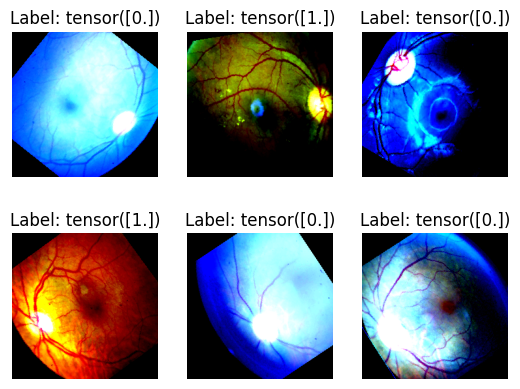

In [7]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [8]:
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE, weights='Weights/RETFound_cfp_weights.pth')
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [9]:
if LOSS == 'focal_loss':
    criterion = BinaryFocalLoss(alpha=1, gamma=2)  # Focal Loss
else:
    criterion = nn.BCEWithLogitsLoss()  #nn.BCELoss()  # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

100%|██████████| 58/58 [01:14<00:00,  1.29s/it]


Epoch 1, Training Loss: 0.19930190772845827


100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


Epoch 1, Validation Loss: 0.21113916713258493, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 2, Training Loss: 0.15003155557246045


100%|██████████| 23/23 [00:25<00:00,  1.11s/it]


Epoch 2, Validation Loss: 0.09754881473339122, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 3, Training Loss: 0.13937075615956865


100%|██████████| 23/23 [00:25<00:00,  1.13s/it]


Epoch 3, Validation Loss: 0.08796401402872542, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 4, Training Loss: 0.12045471678520071


100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


Epoch 4, Validation Loss: 0.11512995948610098, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 5, Training Loss: 0.11738835255904444


100%|██████████| 23/23 [00:25<00:00,  1.11s/it]


Epoch 5, Validation Loss: 0.07902402770907982, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 6, Training Loss: 0.11473936555457526


100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


Epoch 6, Validation Loss: 0.12011574079161105, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 7, Training Loss: 0.1116050650718911


100%|██████████| 23/23 [00:25<00:00,  1.12s/it]


Epoch 7, Validation Loss: 0.0874985255624937, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 8, Training Loss: 0.11003015164671273


100%|██████████| 23/23 [00:25<00:00,  1.11s/it]


Epoch 8, Validation Loss: 0.1439986594993135, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.22s/it]


Epoch 9, Training Loss: 0.0991634921780948


100%|██████████| 23/23 [00:25<00:00,  1.09s/it]


Epoch 9, Validation Loss: 0.09086346982613853, F1 Score: 1.0


100%|██████████| 58/58 [01:10<00:00,  1.22s/it]


Epoch 10, Training Loss: 0.09804260120566549


100%|██████████| 23/23 [00:26<00:00,  1.13s/it]


Epoch 10, Validation Loss: 0.05833847302457561, F1 Score: 1.0


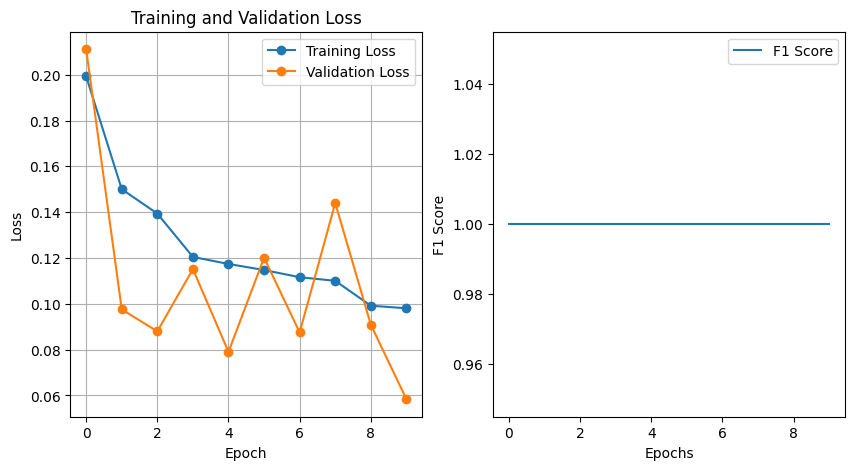

Training finished.


In [10]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=False, device=device)

### Test

  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 130/130 [02:16<00:00,  1.05s/it]


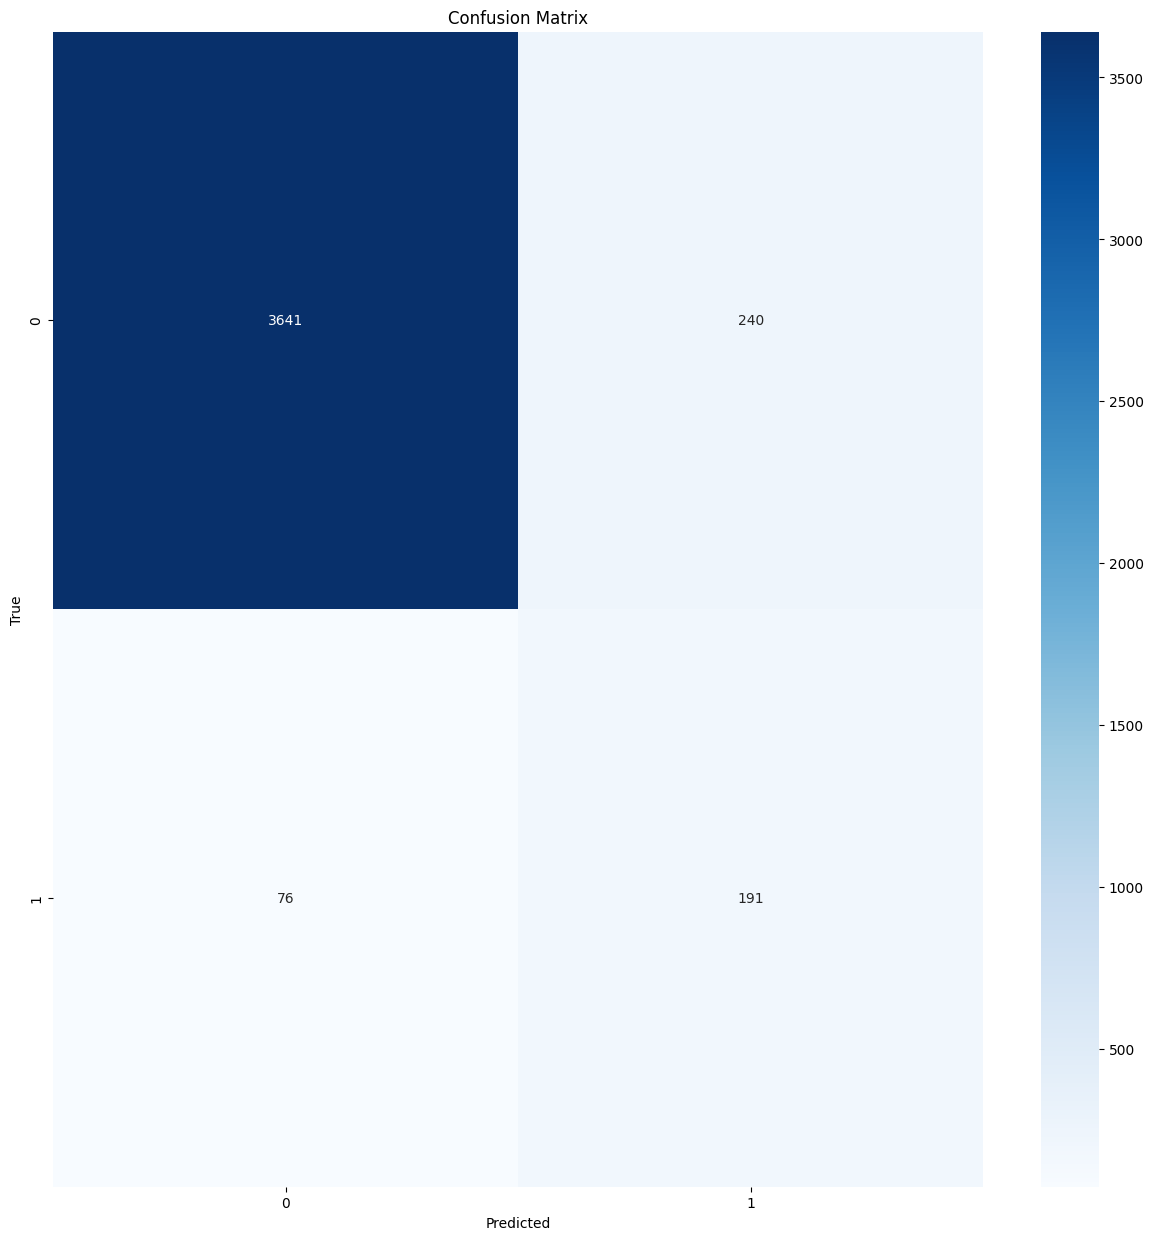

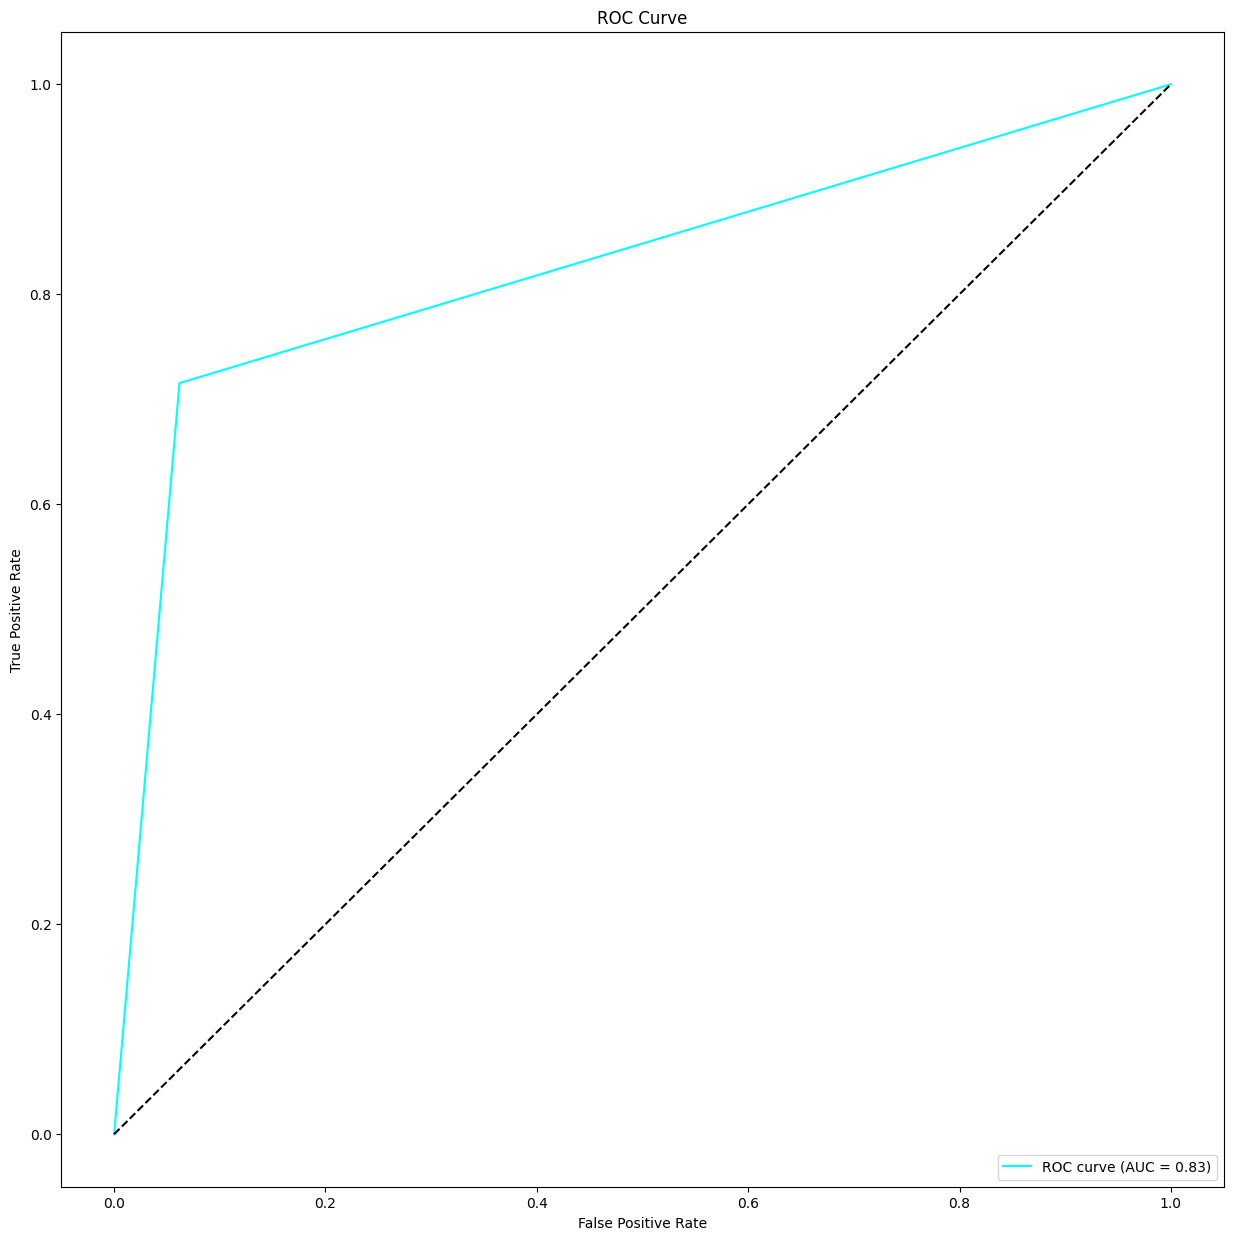

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      3881
         1.0       0.44      0.72      0.55       267

    accuracy                           0.92      4148
   macro avg       0.71      0.83      0.75      4148
weighted avg       0.95      0.92      0.93      4148

##################################################  Saliency Maps  ##################################################

Class 0:


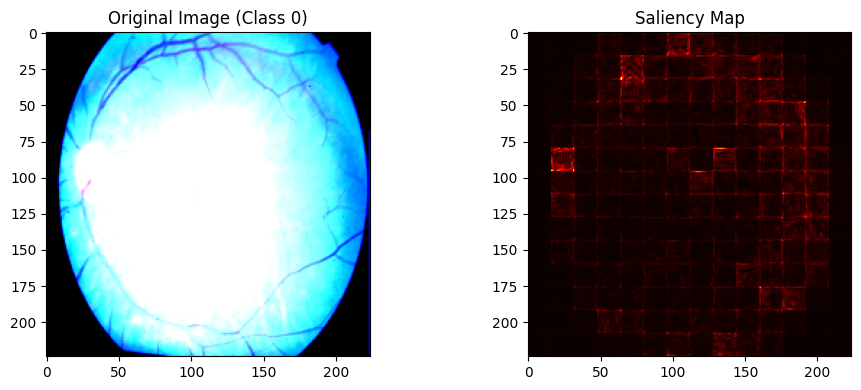

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


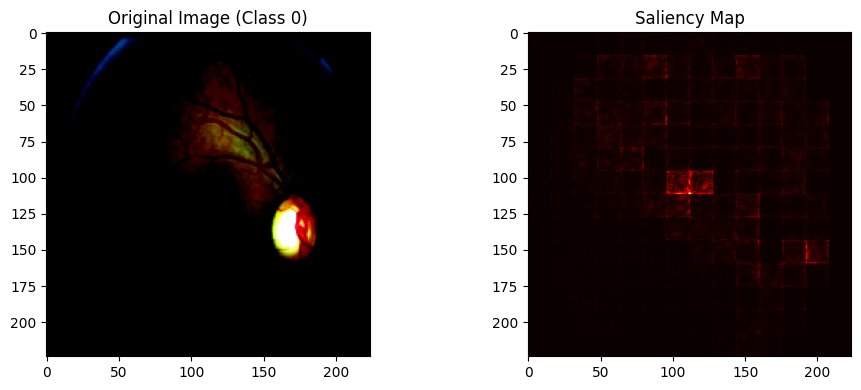

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


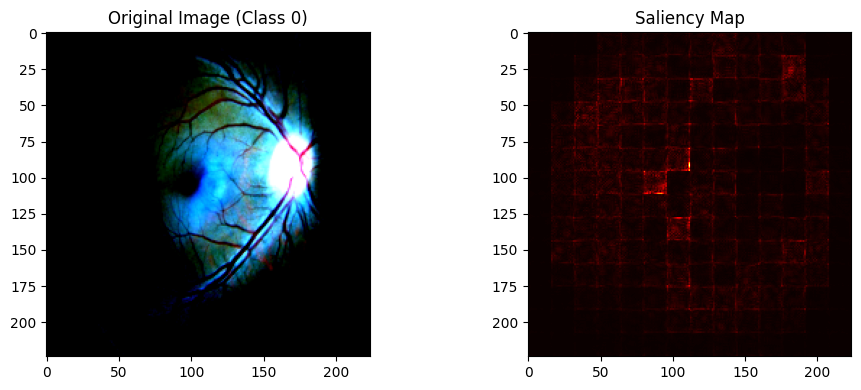

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


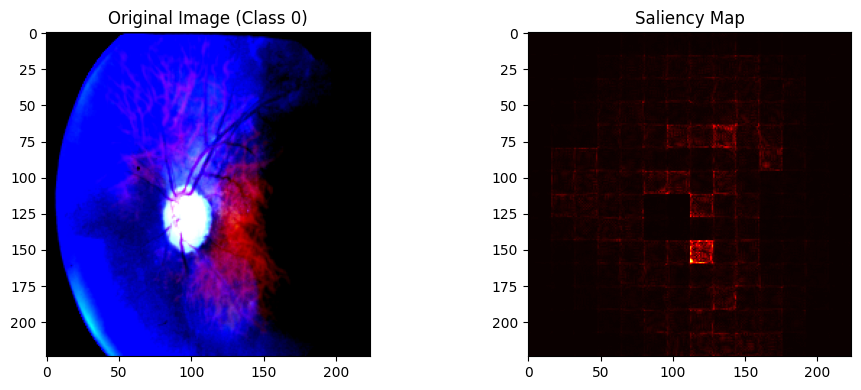

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


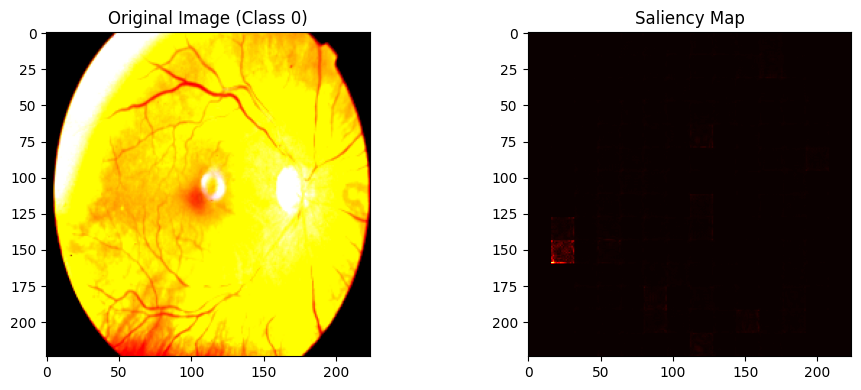

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


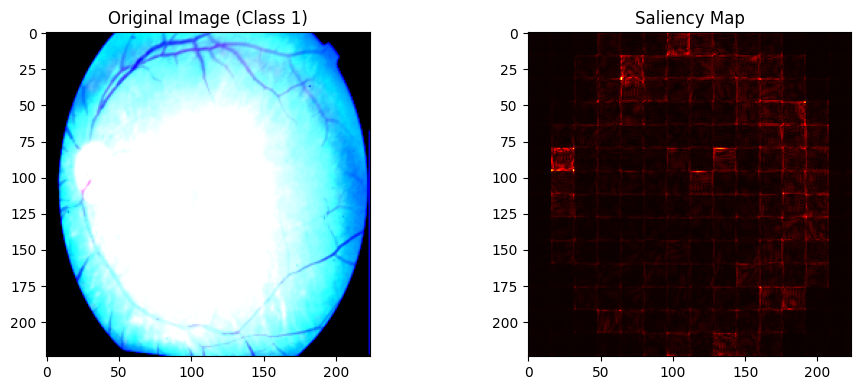

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


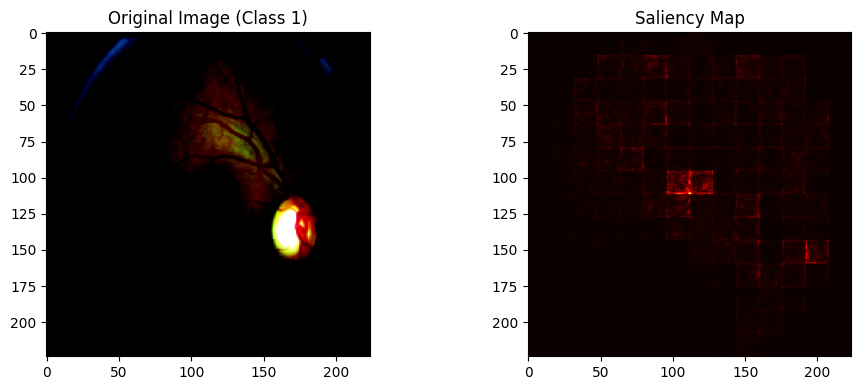

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


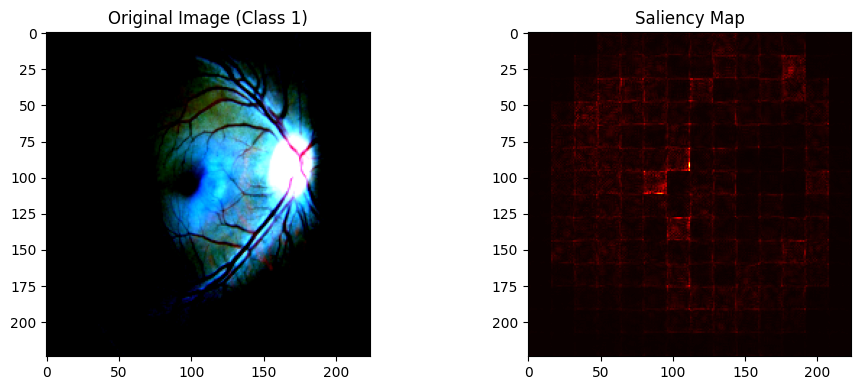

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


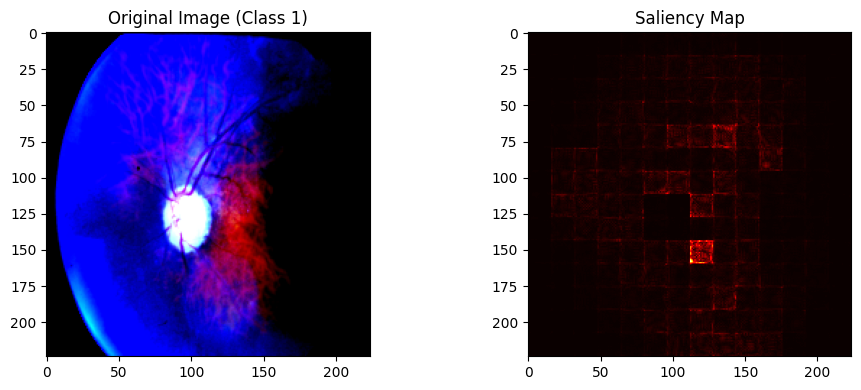

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


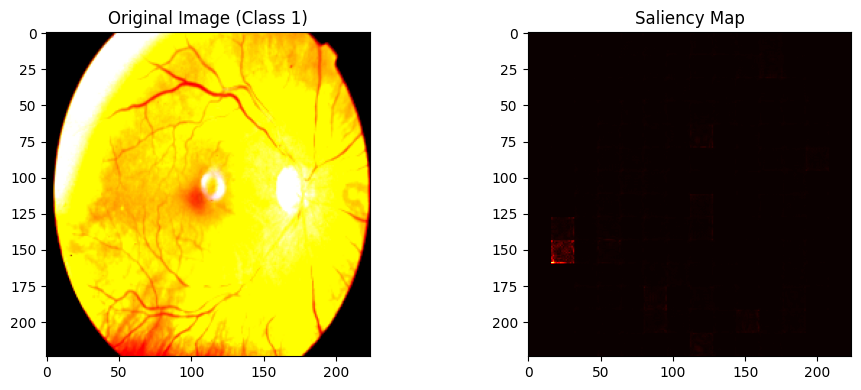

: 

In [11]:
test(model, test_dataloader, saliency=True, device=device)